## **Credit Card Kaggle- Fixing Imbalanced Dataset**
**Context**<br>
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

**Content**<br>
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

**Inspiration**<br>
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

**Acknowledgements**<br>
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

In [25]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [26]:
data = pd.read_csv('creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156612 entries, 0 to 156611
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    156612 non-null  float64
 1   V1      156612 non-null  float64
 2   V2      156611 non-null  float64
 3   V3      156611 non-null  float64
 4   V4      156611 non-null  float64
 5   V5      156611 non-null  float64
 6   V6      156611 non-null  float64
 7   V7      156611 non-null  float64
 8   V8      156611 non-null  float64
 9   V9      156611 non-null  float64
 10  V10     156611 non-null  float64
 11  V11     156611 non-null  float64
 12  V12     156611 non-null  float64
 13  V13     156611 non-null  float64
 14  V14     156611 non-null  float64
 15  V15     156611 non-null  float64
 16  V16     156611 non-null  float64
 17  V17     156611 non-null  float64
 18  V18     156611 non-null  float64
 19  V19     156611 non-null  float64
 20  V20     156611 non-null  float64
 21  V21     15

In [28]:
#Create independent and Dependent Features
columns = data.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting
target = "Class"
# Define a random state
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(156612, 30)
(156612,)


Exploratory Data Analysis

In [29]:
data.isnull().values.any()

np.True_

/tmp/ipython-input-2812369284.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data['Class'], sort = True)


Text(0, 0.5, 'Frequency')

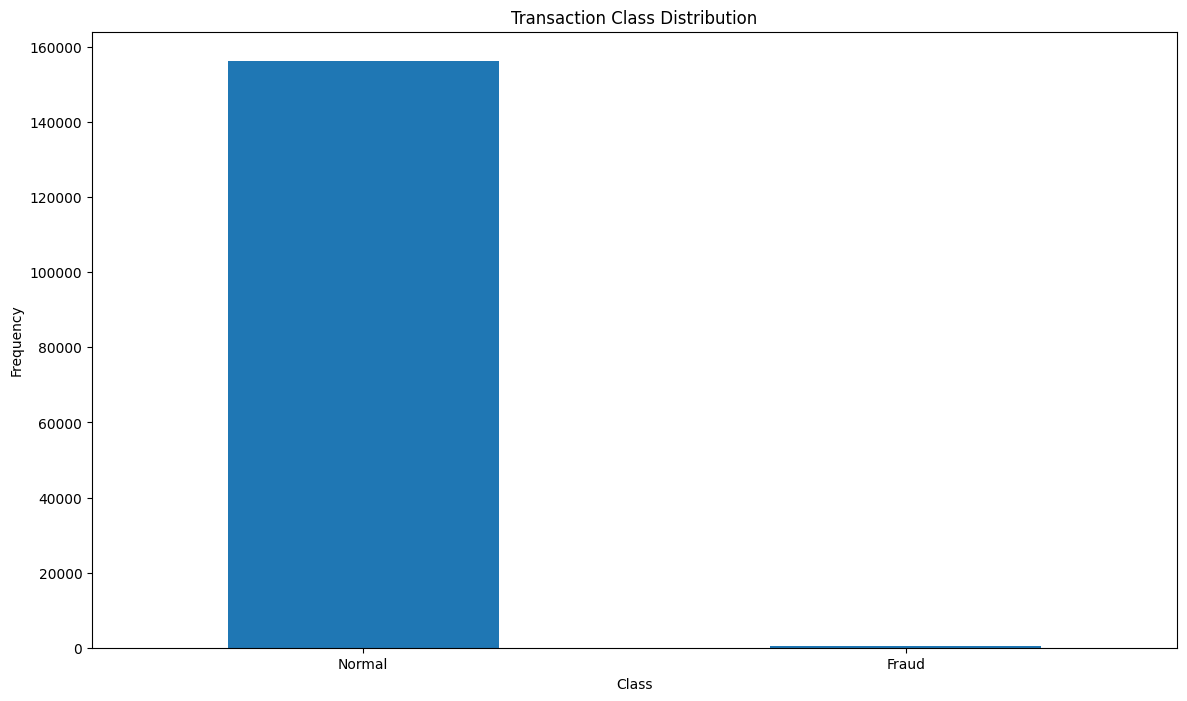

In [30]:
count_classes = pd.value_counts(data['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [31]:
## Get the Fraud and the normal dataset

fraud = data[data['Class']==1]

normal = data[data['Class']==0]
print(fraud.shape,normal.shape)

(350, 31) (156261, 31)


In [32]:
from imblearn.under_sampling import NearMiss
# Combine X and Y temporarily into one DataFrame
data = pd.concat([pd.DataFrame(X), pd.Series(Y, name="target")], axis=1)

# Drop rows where the target is NaN
data = data.dropna(subset=["target"])

# Separate them again
X = data.drop(columns=["target"])
Y = data["target"]
# Implementing Undersampling for Handling Imbalanced
nm = NearMiss()
X_res,y_res=nm.fit_resample(X,Y)
X_res.shape,y_res.shape

((700, 30), (700,))

In [33]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0.0: 156261, 1.0: 350})
Resampled dataset shape Counter({0.0: 350, 1.0: 350})
